[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution


In [46]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

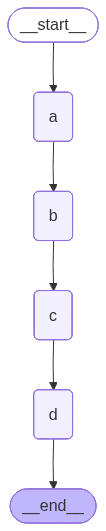

In [47]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

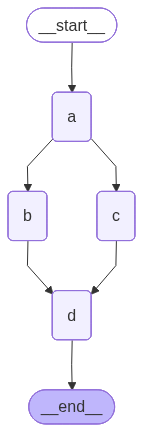

In [49]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**! 

This is because both `b` and `c` are writing to the same state key / channel in the same step. 

In [50]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


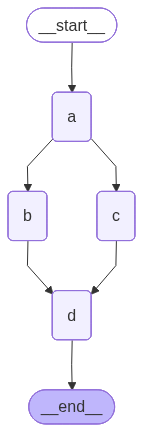

In [51]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

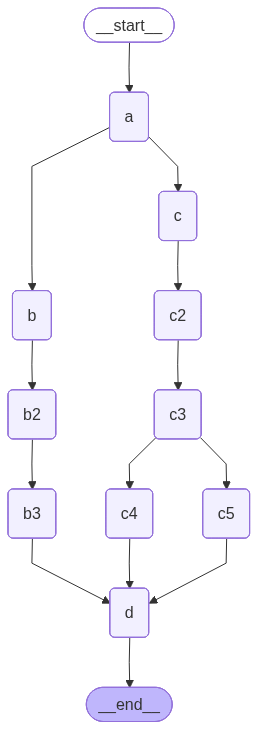

In [53]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("c2", ReturnNodeValue("I'm C2"))
builder.add_node("b3", ReturnNodeValue("I'm B3"))
builder.add_node("c3", ReturnNodeValue("I'm C3"))
builder.add_node("c4", ReturnNodeValue("I'm C4"))
builder.add_node("c5", ReturnNodeValue("I'm C5"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("c", "c2")
builder.add_edge("b2", "b3")
builder.add_edge("c2", "c3")
builder.add_edge("c3", "c4")
builder.add_edge("c3", "c5")
builder.add_edge(["b3", "c4", "c5"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm C2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm B3 to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2"]
Adding I'm C3 to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2"]
Adding I'm C4 to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2", "I'm B3", "I'm C3"]
Adding I'm C5 to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2", "I'm B3", "I'm C3"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2", "I'm B3", "I'm C3", "I'm C4", "I'm C5"]


{'state': ["I'm A",
  "I'm B",
  "I'm C",
  "I'm B2",
  "I'm C2",
  "I'm B3",
  "I'm C3",
  "I'm C4",
  "I'm C5",
  "I'm D"]}

## Setting the order of state updates


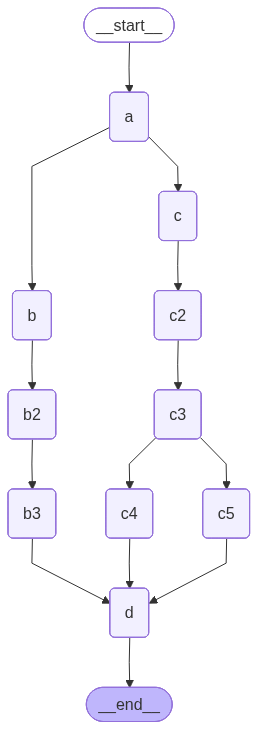

In [55]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("c2", ReturnNodeValue("I'm C2"))
builder.add_node("b3", ReturnNodeValue("I'm B3"))
builder.add_node("c3", ReturnNodeValue("I'm C3"))
builder.add_node("c4", ReturnNodeValue("I'm C4"))
builder.add_node("c5", ReturnNodeValue("I'm C5"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("c", "c2")
builder.add_edge("b2", "b3")
builder.add_edge("c2", "c3")
builder.add_edge("c3", "c4")
builder.add_edge("c3", "c5")
builder.add_edge(["b3", "c4", "c5"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm C2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm B3 to ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm C2"]
Adding I'm C3 to ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm C2"]
Adding I'm C4 to ["I'm A", "I'm B", "I'm B2", "I'm B3", "I'm C", "I'm C2", "I'm C3"]
Adding I'm C5 to ["I'm A", "I'm B", "I'm B2", "I'm B3", "I'm C", "I'm C2", "I'm C3"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm B3", "I'm C", "I'm C2", "I'm C3", "I'm C4", "I'm C5"]


{'state': ["I'm A",
  "I'm B",
  "I'm B2",
  "I'm B3",
  "I'm C",
  "I'm C2",
  "I'm C3",
  "I'm C4",
  "I'm C5",
  "I'm D"]}

## Working with LLMs


In [57]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [58]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [59]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

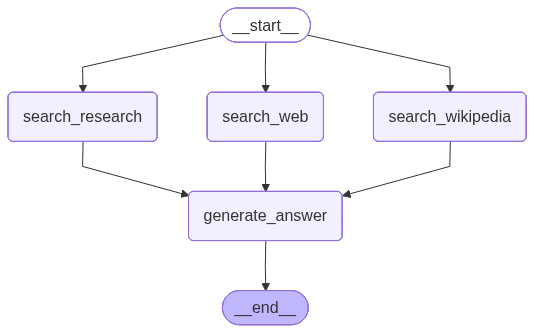

In [60]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_research(state):
    """Retrieve papers from research sites."""
    
    query = f"site:arxiv.org OR site:researchgate.net OR site:scholar.google.com OR site:pubmed.ncbi.nlm.nih.gov {state['question']}"
    tavily_search = TavilySearchResults(max_results=3)
    research_docs = tavily_search.invoke(query)
    
    formatted_research_docs = "\n\n---\n\n".join(
        [
            f'<Paper href="{doc["url"]}">\n{doc["content"]}\n</Paper>'
            for doc in research_docs
        ]
    )
    
    return {"context": [formatted_research_docs]}


def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("search_research", search_research)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge(START, "search_research")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_research", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
result = graph.invoke({"question": "Give me the name of an article on insect metamorphosis"})
result['answer'].content

'The name of an article on insect metamorphosis from the provided context is "The Evolution of Insect Metamorphosis" by James W Truman, published in Current Biology in 2019.'

In [35]:
result = graph.invoke({"question": "What is the top linguistics article in ResearchGate?"})
result['answer'].content

'The top linguistics article in ResearchGate, based on the provided context, is "Trends and hot topics in linguistics studies from 2011 to 2021: A bibliometric analysis of highly cited papers" by Le Zhang.'

## Using with LangGraph API


In [64]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [66]:

thread = await client.threads.create()
input_question = {"question": "What is the top-rated article on Google Scholar about Indic languages?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])